Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [23]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import trange


## The *Nim* and *Nimply* classes

In [24]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [25]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [26]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [27]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [28]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [29]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim, func = nim_sum) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = func(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [30]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <0 0 5 1 9>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <0 0 5 1 6>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 5 0 6>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=5)
INFO:root:status: <0 0 0 0 6>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 0 0 5>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <0 0 0 0 2>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 0 0 1>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


## Rule-based Agent
Our _expert system_ behaves in the following way

1. If there is a move that leaves only one single match remaining, it picks that move
2. Otherwise, looks for a move that sets the nim sum to 0
3. If no moves were found in steps 1 and 2, picks a random move

In [31]:
def expert(state: Nim) -> Nimply:
    analysis = analize(state, lambda s: sum(s.rows))
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, sum in analysis["possible_moves"].items() if sum == 1]  # first step: select a move that leaves only one match (winning move)
    if not spicy_moves:                                                                 # second step: select a move that sets the nim sum to 0
        analysis = analize(state)
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:                                                                 # third step: select a random move
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Evolution Strategies

### Utils

In [32]:
class Individual:
    genotype:float  # a number between 0 and 1, it's the probability of choosing the move with the smallest non-zero nim sum at any given time
    fitness: int

    def __init__(self, genotype) -> None:
        self.genotype = genotype

    def __str__(self) -> str:
        return f"{self.genotype}: {self.fitness}"

    def phenotype(self, state: Nim) -> Nimply:
        analysis = analize(state)
        spicy_moves = [(ply, ns) for ply, ns in analysis["possible_moves"].items() if ns != 0]
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
            return random.choice(spicy_moves)
        if random.random() < self.genotype: # choose the move with the smallest non-zero nim sum
            return min(spicy_moves, key = lambda i: i[1])[0]
        return random.choice(spicy_moves)[0]

In [33]:
def game(player1, player2=pure_random) -> (bool, int):  # plays a game between two different agents, defined as player1 and player2
    nim = Nim(5)
    strategy = (player1, player2)
    player = random.choice((0,1))  # randomly select starting player
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = not player
    return not player  # returns the losing player (1 if the winner is 0 and viceversa) and the duration of the game

In [34]:
def fitness(individual:Individual):  # the fitness is calculated as the winrate and the average number of moves calculated over 100 games
    winrate = 0
    for _ in range(100):
        player2 = expert
        won= game(individual.phenotype, player2)
        winrate += won
    return winrate

In [35]:
ind = Individual(random.random())

ind.fitness = fitness(ind)
print(ind)

0.686823156830746: 9


In [36]:
def graph(individuals):
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Fitness and genotype at different generations')
    axs[0].plot(range(len(individuals)), [individual.fitness for individual in individuals])
    axs[1].plot(range(len(individuals)), [individual.genotype for individual in individuals])
    axs[0].set_ylabel("Fitness")
    axs[1].set_ylabel("Genotype")
    axs[1].set_xlabel("Generation")
    fig.show()

In [37]:
POPULATION_SIZE = 30
OFFSPRING_SIZE = 10
PARENTS_PER_CHILD = 2
TOUR_SIZE = 2
MUTATION_CHANCE = 0.05
SIGMA = 0.2
TOTAL_GENERATIONS = 100

In [38]:
def mutate(ind: Individual):
    return Individual(np.clip(np.random.normal(ind.genotype, SIGMA), 0, 1))

In [39]:
def xover(individuals):
    return Individual(np.average([i.genotype for i in individuals]))

In [40]:
def tour(individuals):
    tournament = [random.choice(individuals) for _ in range(TOUR_SIZE)]
    champion = max(tournament, key=lambda i: i.fitness)
    return champion

In [41]:
# initialize the population
def init_pop():
    population = [Individual(random.random()) for _ in range(POPULATION_SIZE)]
    for p in population:
        p.fitness = fitness(p)
    return population


population = init_pop()

## ($\mu$ + $\lambda$) ES

100%|██████████| 100/100 [11:29<00:00,  6.89s/it]


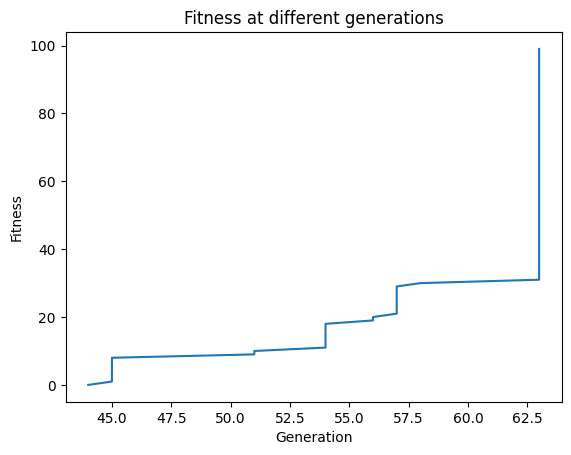

In [42]:
best = list()  # contains the best individual for each population, for graphing purposes

for generation in trange(TOTAL_GENERATIONS):
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_CHANCE: # mutate
            parent = tour(population)
            child = mutate(parent)
        else:
            parents = list()
            for _ in range(PARENTS_PER_CHILD):
                parents.append(tour(population))
            child = xover(parents)
        child.fitness = fitness(child)
        offspring.append(child)
    population.extend(offspring)
    population.sort(key = lambda i: i.fitness, reverse=True)
    population = population[: POPULATION_SIZE]
    best.append(population[0])
graph(best)


## ($\mu$, $\lambda$) ES

In [43]:
POPULATION_SIZE = 10
OFFSPRING_SIZE = 30
PARENTS_PER_CHILD = 2
TOUR_SIZE = 2
MUTATION_CHANCE = 0.05
SIGMA = 0.2
TOTAL_GENERATIONS = 100

population = init_pop()

In [44]:
best = list()

for generation in trange(TOTAL_GENERATIONS):
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_CHANCE: # mutate
            parent = tour(population)
            child = mutate(parent)
        else:
            parents = list()
            for _ in range(PARENTS_PER_CHILD):
                parents.append(tour(population))
            child = xover(parents)
        child.fitness = fitness(child)
        offspring.append(child)
    offspring.sort(key = lambda i: i.fitness, reverse=True)
    population = offspring[: POPULATION_SIZE]
    best.append(population[0])

graph(best)

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [01:04<34:44, 21.49s/it]